In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from torch.autograd import Variable
from utils.datasets import video_loader, mario_loader, make_patches

import matplotlib.pyplot as plt
import numpy as np

torch.Size([5, 3, 32, 32, 500])
torch.float64


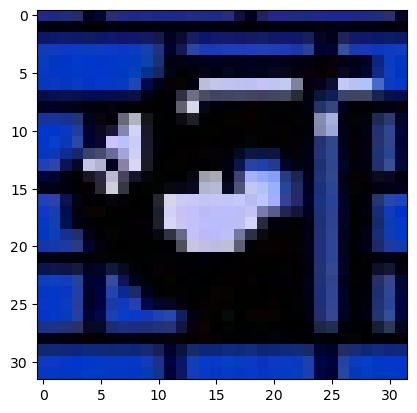

In [2]:
dataset = mario_loader('data/mario_video_train.npy')

#transform = 

loader = DataLoader(dataset, batch_size=5, shuffle=True)

video_batch = next(iter(loader))
print(video_batch.shape)
print(video_batch.dtype)
# print(video_batch[0, :, :, :, 0])
plt.imshow(video_batch[0, :, :, :, 50].permute(1, 2, 0))

torch.Size([5, 3, 4, 256, 1])
torch.Size([3, 256, 1])
5
torch.Size([5, 3, 4, 300, 1])


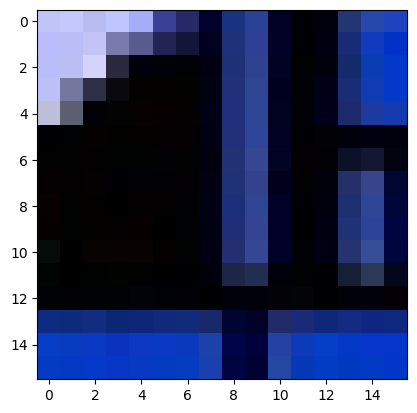

In [3]:
img = make_patches(video_batch[:, :, :, :, 50],16)
print(img.shape)
print(img[0,:,0,:,:].shape)
plt.imshow(img[0, :, 3, :, :].permute(1,2,0).reshape(16,16,-1))
print(len(img))

C = torch.rand(1, 3, 1, 256, 300)
print((C.transpose(-1,-2) @ img.to(torch.float32)).shape)

In [4]:
def patch_to_image(patches, patch_size):
    # patches: [batch, n_patches, 16**2, 1]
    # patch_size: 16
    batch_size, n_channel, n_patch, patch_dim, _ = patches.shape
    patch_size = int(patch_dim ** 0.5)
    grid_size = int(n_patch ** 0.5)
    image = patches.view(batch_size, n_channel, grid_size, grid_size, patch_size, patch_size)
    image = image.permute(0, 1, 2, 4, 3, 5).contiguous()
    image = image.view(batch_size, n_channel, grid_size*patch_size, grid_size*patch_size)
    return image

torch.Size([5, 3, 4, 256, 1])
torch.Size([5, 3, 32, 32])


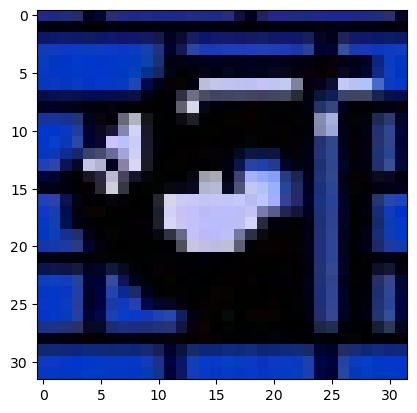

In [5]:
print(img.shape)
ori = patch_to_image(img, 16)
print(ori.shape)
plt.imshow(ori[0,:,:,:].permute(1,2,0))

In [6]:
a = torch.rand(1,1,256,300)
A = a.transpose(-1,-2) @ a
torch.inverse(A).shape

a = torch.rand(1,3,1,256,300)
A = a.transpose(-1,-2) @ a

a0 = a[:,0,:,:,:]
A0 = a0.transpose(-1,-2) @ a0
torch.inverse(A).shape

A0_real = A[:,0,...]

torch.sum(torch.square(A0_real - A0))

tensor(0.)

In [8]:
#import torchvision.transforms as transforms
loader = DataLoader(video_loader('data/Video_train.mat'), batch_size=5, shuffle=False, num_workers=8)
video_batch = next(iter(loader))
# video_batch shape -> (batch_size, num_channels, height, width, num_frames)
print("video sample size: ", video_batch.size())

video sample size:  torch.Size([5, 1, 32, 32, 300])


# Test Splitting an image into patches

test image shape: torch.Size([1, 1, 32, 32])
test image patches shape: torch.Size([1, 1, 2, 2, 16, 16])


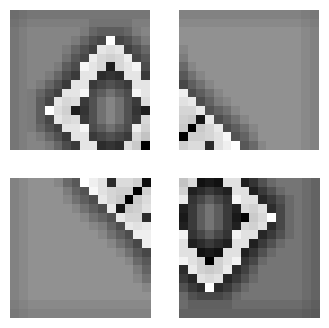

In [9]:
img = video_batch[0,0,:,:,60].unsqueeze(0).unsqueeze(0)
print("test image shape:", img.shape)

step = 12
patch_size = 16
test_patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
print("test image patches shape:", test_patches.shape)
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

for i in range(2):
    for j in range(2):
        ax[i][j].imshow(test_patches[0,0,i,j,:,:], cmap='gray')
        ax[i][j].axis('off')

In [10]:
def make_patches(img, patch_size):
    # outupt shape: (batch, n_patches, patch_size^2, 1)
    try:
        assert img.shape[2] % patch_size == 0
        patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(patches.size(0), -1, patch_size, patch_size).flatten(-2).unsqueeze(-1)
        return patches
    except:
        raise ValueError('Image size must be divisible by patch size')


class Layer(nn.Module):
    def __init__(self, input_dim, state_dim, cause_dim) -> None:
        super().__init__()
        # state transition matrix
        self.A = nn.Parameter(torch.rand(state_dim, state_dim))
        # cause-state nonlinearity matrix
        self.B = nn.Parameter(torch.rand(state_dim, cause_dim))
        # state-observation (reconstruction) matrix
        self.C = nn.Parameter(torch.rand(input_dim, state_dim))
    
    def inference(self, u_prev):
        # initialization x0
        x0 = self.C.t() @ u_prev 
        
        raise NotImplementedError
    
    def forward(self, x):
        raise NotImplementedError

In [11]:
test = make_patches(video_batch[:,:,:,:,60], 16)
print(test.shape)

torch.Size([5, 4, 256, 1])


# Try inference

In [12]:
patches = make_patches(video_batch[:,0,:,:,0].unsqueeze(1), 16)
print("patches shape:", patches.shape)

C = torch.rand(16**2, 300).unsqueeze(0).unsqueeze(0)
print("shape of C:", C.shape)
C = C / C.norm(dim=2, keepdim=True)
output = C.transpose(2,3) @ patches
print("states shape", output.shape)


B = torch.rand(300, 40).unsqueeze(0).unsqueeze(0)
B = B / B.norm(dim=2, keepdim=True)
print("shape of B:", B.shape)
print(patches.shape)

A = torch.rand(300, 300).unsqueeze(0).unsqueeze(0)
A = A / A.norm(dim=2, keepdim=True)
print("shape of A:", A.shape)

patches shape: torch.Size([5, 4, 256, 1])
shape of C: torch.Size([1, 1, 256, 300])
states shape torch.Size([5, 4, 300, 1])
shape of B: torch.Size([1, 1, 300, 40])
torch.Size([5, 4, 256, 1])
shape of A: torch.Size([1, 1, 300, 300])


In [13]:
def S(x):
    x = torch.where(x > 1, torch.ones_like(x), x)
    x = torch.where(x < -1, -torch.ones_like(x), x)
    return x

def soft_thresholding(x, gamma):
    return torch.sign(x) * torch.max(torch.abs(x) - gamma, torch.zeros_like(x))

def f(y, recon, coeff, x_t, pred):
    # calculate the energy function: E(y, recon, coeff, x_t, pred) = 0.5 * ||y - recon||^2 + coeff * ||x_t - pred||_1
    return 0.5 * torch.square(y - recon).flatten(1).sum(1) +\
            coeff * torch.abs(x_t - pred).flatten(1).sum(1)

# Update States

## FISTA

## It may not appear significant, but initialization for inference is very important.

shape of x0: torch.Size([5, 4, 300, 1])
shape of u0: torch.Size([5, 4, 40, 1])
shape of x_hat: torch.Size([5, 4, 300, 1])


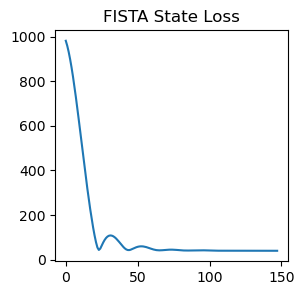

finished in  148 steps
final loss:  [981.3270263671875, 959.2859497070312, 931.676513671875, 899.0521240234375, 861.9478149414062, 820.9049072265625, 776.4788818359375, 729.2427978515625, 679.771728515625, 628.639404296875, 576.4239501953125, 523.6904296875, 470.9953308105469, 418.87652587890625, 367.8385925292969, 318.36541748046875, 270.903076171875, 225.86134338378906, 183.6448974609375, 144.65390014648438, 109.38140869140625, 78.67071533203125, 54.688594818115234, 43.667388916015625, 49.91477966308594, 63.389625549316406, 76.9070816040039, 88.418212890625, 97.3736572265625, 103.67955780029297, 107.41586303710938, 108.74842071533203, 107.89618682861328, 105.11407470703125, 100.68244934082031, 94.90036010742188, 88.0802001953125, 80.54945373535156, 72.66316986083984, 64.80577850341797, 57.42089080810547, 51.02839660644531, 46.218597412109375, 43.51395797729492, 43.077022552490234, 44.520240783691406, 47.11197280883789, 50.15583038330078, 53.145240783691406, 55.75712585449219, 57.8044

In [17]:
# initialization of states and causes
patches = make_patches(video_batch[:,0,:,:,200].unsqueeze(1), 16)
x0 = C.transpose(2,3) @ patches
# x0 = torch.zeros_like(x0)

# normalize x0
#x0 = x0 / x0.norm(dim=2, keepdim=True)
print("shape of x0:", x0.shape)
u0 = B.transpose(2,3) @ x0#torch.randn_like(B.transpose(2,3) @ x0)
u0 = u0 / u0.norm(dim=2, keepdim=True)
print("shape of u0:", u0.shape)

x_hat = A @ x0
print("shape of x_hat:", x_hat.shape)

# mu is the parameter to calculate smoothed ||x_t - Ax_t_1||_1
mu = torch.tensor(2e-4 / 3)
# coefficient for the transition error term
lam = torch.tensor(0.5)
# constant step size for now
L = torch.ones((5))
# extrapolation step size
t_k = torch.tensor(1.0)

# x_k and u_k for computation
x_k = x0.clone()
x_k_1 = x0.clone()
z_k = x0.clone()
u_k = u0.clone()

# 
gamma0 = 1
gamma = torch.div(1 + torch.exp(-B @ u_k), 2)

loss_list_FISTA_X = []
stop_line_search = torch.zeros((5))
thresh = 1e-3
steps = 0
while len(loss_list_FISTA_X) < 2 or abs(loss_list_FISTA_X[-1] - loss_list_FISTA_X[-2]) > thresh:
    # smoothed gradient of ||x_t - Ax_t_1||_1 w.r.t. x_t
    steps+=1
    alpha = (z_k - x_hat) / mu
    alpha = S(alpha)
    
    # gradient of 1/2 * ||y_t - C x_t||_2^2 + lambda * ||x_t - Ax_t_1||_1 w.r.t. x_t
    gradient_xk = C.transpose(2,3) @ (C @ z_k - patches) + lam * alpha
    # print("shape of gradient: ", gradient_xk.shape)
    
    x_k = soft_thresholding(z_k - 1e-4 * gradient_xk, gamma * 1e-4)
    # line search
    '''
    while torch.sum(stop_line_search) < x_k.shape[0]:
        # proximal gradient step
        # x_k = soft_thresholding(z_k - 1e-3 * gradient_xk, 0.0001)#torch.div(gamma, L))
        x_k = soft_thresholding(z_k - torch.div(gradient_xk, L[:, None, None, None]), 
                                torch.div(gamma, L[:, None, None, None]))
        # line search
        energy = f(patches, C @ x_k, lam, x_k, A @ x_k_1)
        upper_bound = f(patches, C @ z_k, lam, z_k, A @ x_k_1) +\
            ((x_k - z_k) * gradient_xk).flatten(1).sum(1) +\
                L / 2 * torch.square(x_k - z_k).flatten(1).sum(1)
        
        stop_line_search = energy <= upper_bound
        L = torch.where(stop_line_search, L, 2 * L)
    print(L)
    '''
    loss_list_FISTA_X.append((torch.norm(patches - C @ x_k) + 0.01 * torch.norm(x_k,1)).item())
    
    # acceleration step
    t_k_1 = torch.div(1 + torch.sqrt(1 + 4 * t_k**2), 2)
    z_k = x_k + torch.div(t_k - 1, t_k_1) * (x_k - x_k_1)
    x_k_1 = x_k.clone()
    t_k = t_k_1
    
plt.figure(figsize=(3,3))
plt.plot(loss_list_FISTA_X)
plt.title("FISTA State Loss")
plt.show()
print("finished in ", steps, "steps")
print("final loss: ", loss_list_FISTA_X)

print("L2 loss", torch.norm(patches - C @ x_k).item())
print("L1 loss", torch.norm(x_k,1).item())

the ratio of zero elements is 11.70%


Text(0, 0.5, 'Frequency')

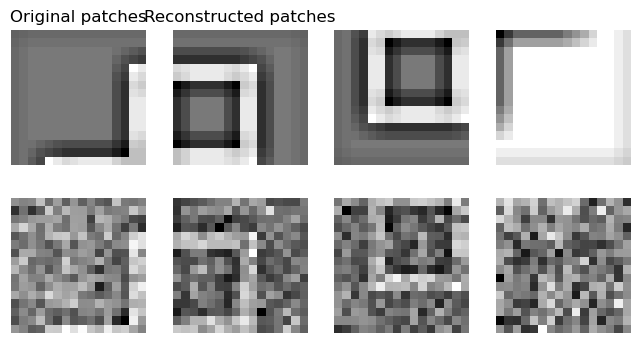

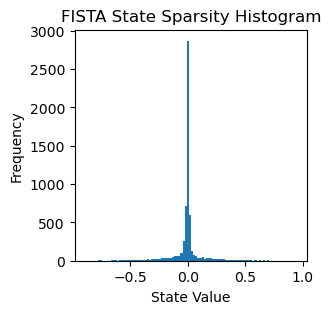

In [18]:

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
for i in range(4):
    ax[0][i].imshow(patches[0,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow((C @ x_k)[0,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[1][i].axis('off')

ax[0][0].set_title('Original patches')
ax[0][1].set_title('Reconstructed patches')


plt.figure(figsize=(3,3))
_ = plt.hist(x_k.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_k)<1e-5)/(x_k.shape[0]*x_k.shape[1]*x_k.shape[2]))*100:.2f}%")
plt.title("FISTA State Sparsity Histogram")
plt.xlabel("State Value")
plt.ylabel("Frequency")

## Update the causese
We need to do average pooling for the patches, and then calculate the causes.

torch.Size([5, 4, 300, 1])
torch.Size([5, 1, 40, 1])
the ratio of zero elements is 0.00%
final loss:  294.31951904296875


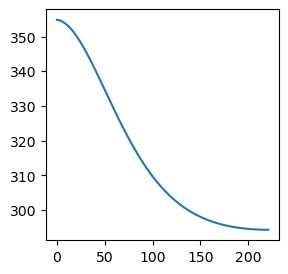

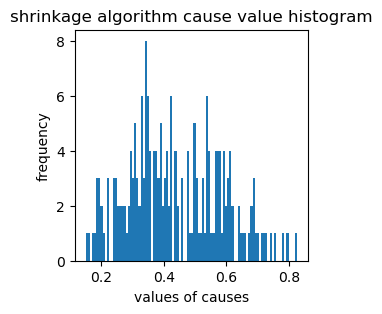

In [20]:
print(x_k.shape)
#x = torch.mean(x_k, dim=1, keepdim=True)
#print(x.shape)

z_k = torch.zeros_like(B.transpose(2,3) @ torch.mean(x_k, dim=1, keepdim=True))
#z_k = B.transpose(2,3) @ torch.mean(x_k, dim=1, keepdim=True)
u_k_1 = z_k.clone()
loss_list_FISTA_u = []

x = torch.sum(torch.abs(x_k), dim=1, keepdim=True)
while len(loss_list_FISTA_u) < 2 or abs(loss_list_FISTA_u[-1] - loss_list_FISTA_u[-2]) > thresh:
    # gradient of 1/2 * ||y_t - C x_t||_2^2 + lambda * ||x_t - Ax_t_1||_1 w.r.t. u_t
    exp_func = torch.exp(-B @ z_k) / 2
    gradient_uk = -B.transpose(2,3) @ (exp_func * x)
    # print("shape of gradient: ", gradient_xk.shape)
    
    u_k = soft_thresholding(z_k - 1e-4 * gradient_uk, 1e-4)
    loss_list_FISTA_u.append((0.5 * torch.norm(u_k,1) + torch.norm(x * (1+torch.exp(-B @ u_k))/2,1)).item())
    
    # acceleration step
    t_k_1 = torch.div(1 + torch.sqrt(1 + 4 * t_k**2), 2)
    z_k = u_k + torch.div(t_k - 1, t_k_1) * (u_k - u_k_1)
    u_k_1 = u_k.clone()
    t_k = t_k_1
    
print(u_k.shape)
plt.figure(figsize=(3,3))
plt.plot(loss_list_FISTA_u)

plt.figure(figsize=(3,3))
_ = plt.hist(u_k.numpy().flatten(), bins=100)
plt.title('shrinkage algorithm cause value histogram')
plt.xlabel('values of causes')
plt.ylabel('frequency')
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(u_k)<1e-5)/(u_k.shape[0]*u_k.shape[1]*u_k.shape[2]))*100:.2f}%")
print("final loss: ", loss_list_FISTA_u[-1])

In [ ]:
u_k.min()


tensor(0.7481)

## Shrinkage

In [21]:
print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

A shape: torch.Size([1, 1, 300, 300])
B shape: torch.Size([1, 1, 300, 40])
C shape: torch.Size([1, 1, 256, 300])


In [22]:
(B.transpose(2,3) @ x0).shape
torch.tile(torch.div(1 + torch.exp(-B @ u_k), 2), (1,4,1,1)).shape

torch.Size([5, 4, 300, 1])

shape of x0: torch.Size([5, 4, 300, 1])
shape of u0: torch.Size([5, 4, 40, 1])
shape of x_hat: torch.Size([5, 4, 300, 1])
tensor(0.3000)
the ratio of zero elements is 21.00%
final loss:  [50.292640686035156, 48.25452423095703]
L2 Loss 21.639535903930664
L1 Loss 2639.066650390625


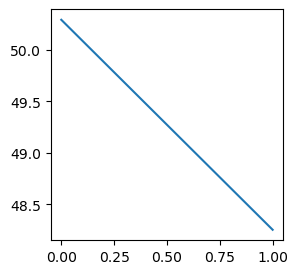

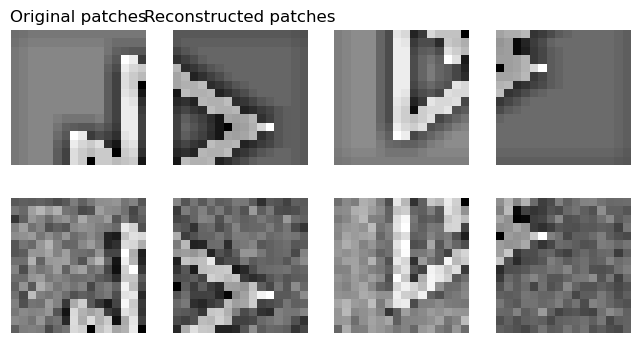

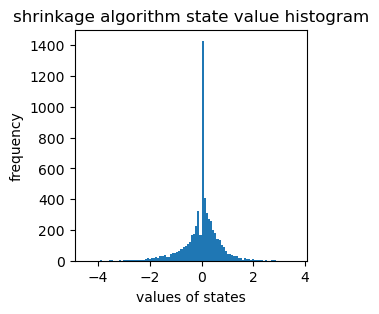

In [27]:
patches = make_patches(video_batch[:,0,:,:,120].unsqueeze(1), 16)
x0 = C.transpose(2,3) @ patches
#x0 = x0 / x0.norm(dim=2, keepdim=True)
# x0 = torch.zeros_like(x0)
print("shape of x0:", x0.shape)
# u0 = torch.zeros_like(B.transpose(2,3) @ x0)
u0 = torch.rand_like(B.transpose(2,3) @ x0)
u0 = u0 / u0.norm(dim=2, keepdim=True)
print("shape of u0:", u0.shape)
gamma = torch.div(1 + torch.exp(-B @ u0), 2)

x_hat = A @ x0
print("shape of x_hat:", x_hat.shape)

lam = torch.tensor(0.5)

loss_list_X_Shrinkage = []

# print(patches_test.shape)
I = torch.eye(256).unsqueeze(0).unsqueeze(0)

y = patches
x_k = x0
#print(y.shape)
mu = torch.abs((C.transpose(2,3) @ y)).min()
mu = torch.tensor(.3)
print(mu)

Cy = C.transpose(2,3) @ y
for i in range(2):
    # update u

    alpha = (x_k - x_hat) / mu
    alpha = S(alpha)

    Cyla = Cy - lam * alpha
    W_inv = torch.div(torch.abs(x_k), gamma * 0.1)
    x_k = W_inv * Cyla - (W_inv.transpose(2,3) * C).transpose(2,3) @ \
            torch.inverse(I+(C * W_inv.transpose(2,3)) @ C.transpose(2,3)) @ \
                    ((C * W_inv.transpose(2,3)) @ Cyla)
    loss_list_X_Shrinkage.append((torch.norm(y - C @ x_k) + 0.01 * torch.norm(x_k,1)).item())

x_index = x_k / torch.norm(x_k)
x_index = torch.abs(x_index) < 1e-3
x_k[x_index] = 0
#for _ in range(10):
#    W_inv = 
plt.figure(figsize=(3,3))
plt.plot(loss_list_X_Shrinkage)


idx = 0
fig, ax = plt.subplots(2, 4, figsize=(8, 4))
for i in range(4):
    ax[0][i].imshow(patches[idx,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow((C @ x_k)[idx,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[1][i].axis('off')

ax[0][0].set_title('Original patches')
ax[0][1].set_title('Reconstructed patches')

plt.figure(figsize=(3,3))
_ = plt.hist(x_k.numpy().flatten(), bins=100)
plt.title('shrinkage algorithm state value histogram')
plt.xlabel('values of states')
plt.ylabel('frequency')
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_k)<1e-5)/(x_k.shape[0]*x_k.shape[1]*x_k.shape[2]))*100:.2f}%")
print("final loss: ", loss_list_X_Shrinkage)

print('L2 Loss', torch.norm(patches - C @ x_k).item())
print('L1 Loss', torch.norm(x_k,1).item())

# Update Causes

the ratio of zero elements is 23.00%
final loss:  69.47928619384766
torch.Size([5, 1, 40, 1])


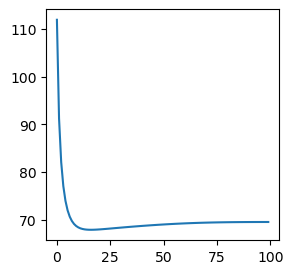

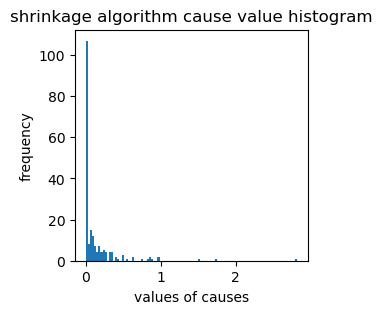

In [31]:
# sparsity level for causes
x = torch.mean(x_k, dim=1, keepdim=True)
#u_k = torch.randn_like(B.transpose(2,3) @ x)
# initialization of u_0
u_k = B.transpose(2,3) @ x
beta = 2.
loss_list_u_shrinkage = []
loss_list_test_u = []
x_abs = torch.sum(torch.abs(x_k), dim=1, keepdim=True)

gamma0 = .1
for i in range(100):
    W_inv = torch.div(torch.abs(u_k), beta)
    u_k = W_inv * B.transpose(2,3) @ (gamma0 * x_abs * torch.exp(-B @ u_k))
    loss_list_u_shrinkage.append((beta * torch.norm(u_k,1) + torch.norm(x * (1+torch.exp(-B @ u_k))/2)).item())
    # loss_list_test_u.append(torch.norm(B @ u_k - x_k).item())
    
u_index = u_k / torch.norm(u_k)
u_index = torch.abs(u_index) < 1e-3
u_k[u_index] = 0
plt.figure(figsize=(3,3))
plt.plot(loss_list_u_shrinkage)

plt.figure(figsize=(3,3))
_ = plt.hist(u_k.numpy().flatten(), bins=100)
plt.title('shrinkage algorithm cause value histogram')
plt.xlabel('values of causes')
plt.ylabel('frequency')
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(u_k)<1e-5)/(u_k.shape[0]*u_k.shape[1]*u_k.shape[2]))*100:.2f}%")
print("final loss: ", loss_list_u_shrinkage[-1])

print(u_k.shape)

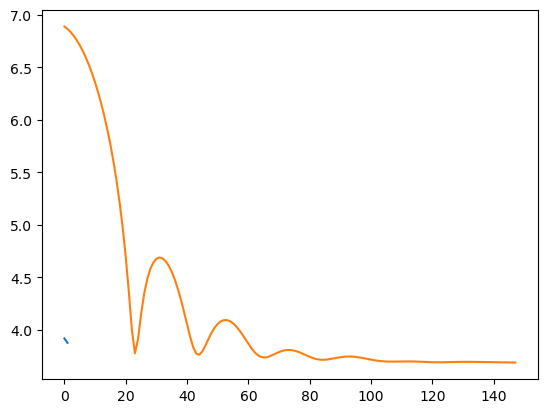

In [34]:
plt.plot(np.log(loss_list_X_Shrinkage))
plt.plot(np.log(loss_list_FISTA_X))

# Try Alternating Minimization

sparsity ratio x 0.0
sparsity ratio x 0.0
sparsity ratio x 0.0
sparsity ratio x 0.0028333333333333335
sparsity ratio x 0.0245
sparsity ratio u 0.0
sparsity ratio u 0.88
sparsity ratio u 0.88
sparsity ratio u 0.88
sparsity ratio u 0.88


Text(0, 0.5, 'Frequency')

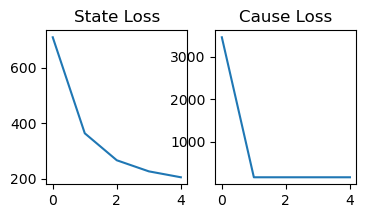

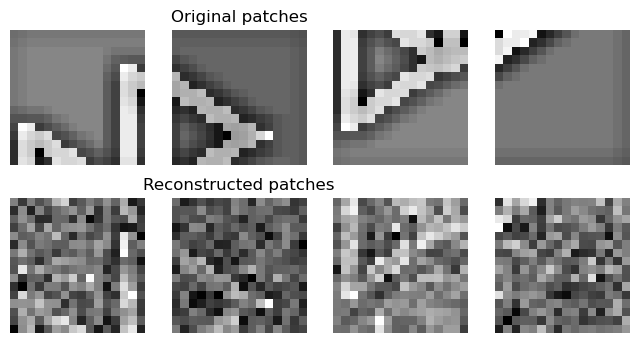

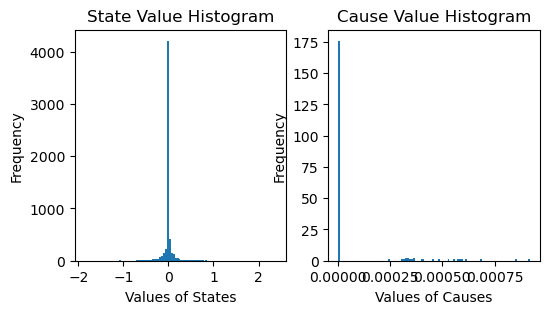

In [ ]:
torch.manual_seed(0)

C = torch.rand(16**2, 300).unsqueeze(0).unsqueeze(0)
#print("shape of C:", C.shape)
C = C / C.norm(dim=2, keepdim=True)
output = C.transpose(2,3) @ patches
#print("states shape", output.shape)


B = torch.rand(300, 40).unsqueeze(0).unsqueeze(0)
B = B / B.norm(dim=2, keepdim=True)
#print("shape of B:", B.shape)
#print(patches.shape)

A = torch.rand(300, 300).unsqueeze(0).unsqueeze(0)
A = A / A.norm(dim=2, keepdim=True)
#print("shape of A:", A.shape)


idx = np.random.randint(0, 300, 1)[0]
patches = make_patches(video_batch[:,0,:,:,idx].unsqueeze(1), 16)
# x0 = C.transpose(2,3) @ patches
x0 = torch.randn_like(C.transpose(2,3) @ patches)


#print("shape of x0:", x0.shape)
u0 = torch.zeros_like(B.transpose(2,3) @ x0)
#print("shape of u0:", u0.shape)
gamma = torch.div(1 + torch.exp(-B @ u0), 2)

x_hat = A @ x0
#print("shape of x_hat:", x_hat.shape)

# parameter for the transition error term
lam = torch.tensor(0.5)

loss_list = []
loss_list_u = []
# print(patches_test.shape)
I = torch.eye(256).unsqueeze(0).unsqueeze(0)
I_u = torch.eye(300).unsqueeze(0).unsqueeze(0)
y = patches

# initialization of states and causes
x_k = x_hat.clone()#x0.clone()


mu = torch.tensor(.3)
Cy = C.transpose(2,3) @ y

# sparsity level for states
sparsity = 0.5

# beta controls sparsity for u
beta = 0.5

for _ in range(1):

    for i in range(5):
        # update states

        alpha = (x_k - x_hat) / mu
        alpha = S(alpha)
        
        Cyla = Cy - lam * alpha
        W_inv = torch.div(torch.abs(x_k), sparsity * gamma)
        
        x_k = W_inv * Cyla - (W_inv.transpose(2,3) * C).transpose(2,3) @ \
                torch.inverse(I+(C * W_inv.transpose(2,3)) @ C.transpose(2,3)) @ \
                        ((C * W_inv.transpose(2,3)) @ Cyla)
        x_index = torch.abs(x_k) < 1e-8
        x_k[x_index] = 0
        print("sparsity ratio x", (x_k.numpy()==0).sum()/x_k.numpy().size)
        loss_list.append((torch.norm(y - C @ x_k) + sparsity * torch.norm(x_k,1)).item())

    x_index = x_k / torch.norm(x_k)
    x_index = torch.abs(x_index) < 1e-3
    x_k[x_index] = 0
    
    # sparsity level for causes
    x = torch.mean(x_k, dim=1, keepdim=True)
    u_k = torch.randn_like(B.transpose(2,3) @ x)
    # initialization of u_0
    #u_k = B.transpose(2,3) @ x_k
    

    x_abs = torch.sum(torch.abs(x_k), dim=1, keepdim=True)

    Bx = B.transpose(2,3) @ x_k
    for i in range(5):
        W_inv = torch.div(torch.abs(u_k), beta)
        u_k = W_inv * B.transpose(2,3) @ (sparsity * x_abs * torch.exp(-B @ u_k))
        #u_k = W_inv * Bx - (W_inv.transpose(2,3) * B).transpose(2,3) @ \
        #        torch.inverse(I_u+(B * W_inv.transpose(2,3)) @ B.transpose(2,3)) @ \
        #                ((B * W_inv.transpose(2,3)) @ Bx)
        u_index = torch.abs(u_k) < 1e-5
        u_k[u_index] = 0
        print("sparsity ratio u", (u_k.numpy()==0).sum()/u_k.numpy().size)
        loss_list_u.append((beta * torch.norm(u_k,1) + sparsity * torch.norm(x_k * gamma,1).item()))
        #loss_list_u.append((beta * torch.norm(u_k,1) + torch.norm(B @ u_k - x_k)).item())
    u_index = u_k / torch.norm(u_k)
    u_index = torch.abs(u_index) < 1e-3
    u_k[u_index] = 0
    
    gamma = torch.tile(torch.div(1 + torch.exp(-B @ u_k), 2), (1,4,1,1))

fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].plot(loss_list)
ax[0].set_title('State Loss')
ax[1].plot(loss_list_u)
ax[1].set_title('Cause Loss')

idx = np.random.randint(0, 4, 1)[0]
fig, ax = plt.subplots(2, 4, figsize=(8, 4))
for i in range(4):
    ax[0][i].imshow(patches[idx,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow((C @ x_k)[idx,i,:,:].squeeze().numpy().reshape(16,16), cmap='gray')
    ax[1][i].axis('off')

ax[0][1].set_title('Original patches')
ax[1][1].set_title('Reconstructed patches')


fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].hist(x_k.numpy().flatten(), bins=100)
ax[0].set_title('State Value Histogram')
ax[0].set_xlabel('Values of States')
ax[0].set_ylabel('Frequency')

ax[1].hist(u_k.numpy().flatten(), bins=100)
ax[1].set_title('Cause Value Histogram')
ax[1].set_xlabel('Values of Causes')
ax[1].set_ylabel('Frequency')

In [ ]:
u_k.shape

torch.Size([5, 1, 40, 1])

In [ ]:
print((u_k==0).sum() / 200)
u_k[4,0,:,0]

tensor(0.7750)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
recon = C @ x_k
print(recon[0,0,:,:].max(), recon[0,0,:,:].min())
print(Cy.max(), Cy.min())
print(torch.norm(C))
print(W_inv.max(), W_inv.min())
print(beta)

tensor(0.1824) tensor(-0.2943)
tensor(0.5752) tensor(-1.7908)
tensor(17.3205)
tensor(0.0757) tensor(0.)
1.5


In [ ]:
C@ x_k

tensor([[[[-1.4876e-01],
          [-2.1727e-01],
          [-1.4271e-01],
          ...,
          [ 1.4465e-02],
          [-5.2662e-02],
          [-2.2373e-01]],

         [[-3.1630e-03],
          [-2.4025e-02],
          [-2.1486e-02],
          ...,
          [-1.4997e-02],
          [-1.8157e-02],
          [ 6.6359e-03]],

         [[-4.8694e-02],
          [ 1.7859e-02],
          [ 6.9418e-02],
          ...,
          [-4.6095e-02],
          [ 1.2483e-02],
          [ 2.7744e-02]],

         [[-2.1749e-02],
          [-8.7699e-02],
          [-1.9204e-01],
          ...,
          [-1.2006e-01],
          [-8.9076e-03],
          [-2.8332e-01]]],


        [[[-7.4946e-02],
          [-8.1974e-02],
          [-7.7000e-02],
          ...,
          [ 1.1873e-02],
          [ 8.0884e-02],
          [-2.7797e-01]],

         [[-6.4132e-02],
          [-5.2793e-02],
          [-3.6647e-02],
          ...,
          [-6.6833e-02],
          [-6.5100e-02],
          [-3.2489e-02]

In [ ]:
torch.mean(torch.abs(C @ x_k))

tensor(0.0758)